# KdV Experiment (Solving Partial Differential Equations)

Import the libraries.

In [1]:
import os
import sys

import h5py
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from resnet1d import ResNet1D

Import the S-MNN module.

In [2]:
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__) if '__file__' in globals() else '', '..', '..')))
from smnn import ode_forward

## Helper Functions

### Data Processing

In [3]:
class KDVDataset(Dataset):
    def __init__(self, steps_per_example: int, kind='train', device=torch.device('cpu')):
        self.steps_per_example = steps_per_example
        data_root = 'KDV_easy'
        if kind=='train':
            file = os.path.join(data_root,'KdV_train_512_easy.h5')
            h5_path = 'train/pde_140-256'
        elif kind=='valid':
            file = os.path.join(data_root,'KdV_valid_easy.h5')
            h5_path = 'valid/pde_140-256'
        elif kind=='test':
            file = os.path.join(data_root,'KdV_test_easy.h5')
            h5_path = 'test/pde_140-256'
        else:
            raise ValueError('Invalid dataset type') 

        data = np.array(h5py.File(file, 'r').get(h5_path))  # float64, (512, 140, 256)
        self.data = torch.as_tensor(data, dtype=torch.float32, device=device)
        self.n_trajectory = self.data.shape[0]  # 512
        self.n_time_steps = self.data.shape[1]  # 140
        print('data module ', kind, self.data.shape, self.n_time_steps)
        self.length_per_trajectory = self.n_time_steps - self.steps_per_example * 2 + 2

    def __len__(self):
        return self.length_per_trajectory * self.n_trajectory

    def __getitem__(self, idx):
        traj_idx = idx // self.length_per_trajectory
        time_idx = idx % self.length_per_trajectory

        x = self.data[traj_idx, time_idx : time_idx + self.steps_per_example]
        y = self.data[traj_idx, time_idx + self.steps_per_example - 1 : time_idx + self.steps_per_example * 2 - 1]
        return x, y

In [4]:
class KDVDataModule(pl.LightningDataModule):
    def __init__(self, steps_per_example: int, batch_size: int, device: torch.device = torch.device('cpu')):
        super().__init__()
        self.train_dataset = KDVDataset(steps_per_example=steps_per_example, kind='train', device=device)
        self.valid_dataset = KDVDataset(steps_per_example=steps_per_example, kind='valid', device=device)
        self.test_dataset = KDVDataset(steps_per_example=steps_per_example, kind='test', device=device)
        self.steps_per_example = steps_per_example
        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=True, num_workers=0)

    def val_dataloader(self):
        return DataLoader(self.valid_dataset, batch_size=self.batch_size, drop_last=True, shuffle=False, num_workers=0)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)

### Model Definition

In [5]:
class Method(pl.LightningModule):
    def __init__(self, steps_per_example: int):
        super().__init__()
        step_size_t = .05
        order = 4

        n_ind_dim = 256
        self.n_step = steps_per_example

        pm = 'circular'

        self.cf_cnn = nn.Sequential(
            ResNet1D(
                in_channels=10,
                base_filters=64,
                kernel_size=9,
                stride=1,
                groups=1,
                n_block=10,
                n_classes=2,
                use_bn=False,
                use_do=False,
            ),
            nn.Conv1d(256, self.n_step * (order + 1), kernel_size=7, padding=3, stride=1, padding_mode=pm),
        )

        self.rhs_cnn = nn.Sequential(
            ResNet1D(
                in_channels=10,
                base_filters=64,
                kernel_size=9,
                stride=1, groups=1,
                n_block=10,
                n_classes=2,
                use_bn=False,
                use_do=False,
            ),
            nn.Conv1d(256, self.n_step, kernel_size=7, padding=3, stride=1, padding_mode=pm),
        )

        self.iv_cnn = nn.Sequential(
            nn.Conv1d(10, 64, kernel_size=7, padding=3, stride=1, padding_mode=pm),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=7, padding=3, stride=1, padding_mode=pm),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=7, padding=3, padding_mode=pm),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=7, padding=3, padding_mode=pm),
            nn.ReLU(),
            nn.Conv1d(256, 128, kernel_size=7, padding=3, stride=2, padding_mode=pm),
            nn.ReLU(),
            nn.Conv1d(128, 64, kernel_size=7, padding=3, stride=2, padding_mode=pm),
            nn.ReLU(),
            nn.Conv1d(64, 32, kernel_size=7, padding=3, stride=1, padding_mode=pm),
            nn.Flatten(),
            nn.Linear(32 * 64, n_ind_dim * (order - 1)),
            nn.Unflatten(dim=-1, unflattened_size=[n_ind_dim, order - 1]),
        )

        steps_layer_t = nn.Linear(32 * 64, 1)
        steps_layer_t.weight.data.fill_(0.)
        steps_layer_t.bias.data.fill_(torch.tensor(step_size_t).logit())  # set step bias to set initial step
        self.step_cnn = nn.Sequential(
            nn.Conv1d(10, 64, kernel_size=5, padding=2, stride=1, padding_mode=pm),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, padding=2, stride=2, padding_mode=pm),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=5, padding=2, padding_mode=pm),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=5, padding=2, padding_mode=pm),
            nn.ReLU(),
            nn.Conv1d(256, 128, kernel_size=5, padding=2, stride=1, padding_mode=pm),
            nn.ReLU(),
            nn.Conv1d(128, 64, kernel_size=5, padding=2, stride=2, padding_mode=pm),
            nn.ReLU(),
            nn.Conv1d(64, 32, kernel_size=5, padding=2, stride=1, padding_mode=pm),
            nn.Flatten(),
            steps_layer_t,
            nn.Sigmoid(),
        )

    def forward(self, x):
        # x: (32, 10, 256)
        coefficients = self.cf_cnn(x).permute(0, 2, 1)  # (32, 256, 50)
        rhs_equation = self.rhs_cnn(x).permute(0, 2, 1)  # (32, 256, 10)
        steps = self.step_cnn(x).clip(min=1e-3)[:, None, :].repeat(1, coefficients.size(-2), self.n_step - 1)  # (32, 256, 9)

        init_vars = torch.cat([
            x[:, -1, :, None],  # (32, 256, 1)
            self.iv_cnn(x),    # (32, 256, 3)
        ], dim=-1)  # (32, 256, 4)

        batch_size, n_ind_dim, order = init_vars.shape
        solver_dtype = torch.float64

        coefficients = coefficients.reshape(batch_size, n_ind_dim, self.n_step, 1, 1, order + 1).to(dtype=solver_dtype)  # (32, 256, 10, 1, 1, 5)
        rhs_equation = rhs_equation.reshape(batch_size, n_ind_dim, self.n_step, 1).to(dtype=solver_dtype)  # (32, 256, 10, 1)
        init_vars = init_vars.reshape(batch_size, n_ind_dim, 1, 1, order).to(dtype=solver_dtype)  # (32, 256, 1, 1, 4)
        steps = steps.reshape(batch_size, n_ind_dim, self.n_step - 1).to(dtype=solver_dtype)  # (32, 256, 9)

        u = ode_forward(coefficients, rhs_equation, init_vars, steps, is_step_dim_first=False, enable_central_smoothness=False)  # (32, 256, 10, 1, 5)

        u = u[..., 0, 0].transpose(-2, -1).to(dtype=x.dtype)  # (32, 10, 256)
        return u

    def loss(self, batch):
        x, y = batch[0], batch[1]
        u = self.forward(x)
        loss = (u - y).abs().sum(dim=-1).mean()
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.loss(batch)
        self.log('train_loss', loss, prog_bar=True, logger=True, on_epoch=True, on_step=True)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        loss = self.loss(batch)
        self.log('val_loss', loss, prog_bar=True, logger=True, on_epoch=True, on_step=True)
        return {'loss': loss}

    def test_step(self, batch, batch_idx):
        loss = self.loss(batch)
        self.log('test_loss', loss, prog_bar=True, logger=True, on_epoch=True, on_step=True)
        return {'loss': loss}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        lr_scheduler_config = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=.5, patience=2),
            'interval': 'epoch',
            'frequency': self.trainer.check_val_every_n_epoch,
            'monitor': 'val_loss',
            'strict': True,
            'name': None,
        }
        return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler_config}

## Running Experiment

Generate train data.

In [6]:
datamodule = KDVDataModule(steps_per_example=10, batch_size=32, device=torch.device('cpu'))

data module  train torch.Size([512, 140, 256]) 140
data module  valid torch.Size([512, 140, 256]) 140
data module  test torch.Size([512, 140, 256]) 140


Initialize the model.

In [7]:
method = Method(steps_per_example=datamodule.steps_per_example)

Train the model.

In [8]:
trainer = pl.Trainer(
    max_epochs=10,
    check_val_every_n_epoch=5,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    callbacks=[
        pl.callbacks.ModelCheckpoint(filename='{epoch:04}-{step:06}-{val_loss:.6f}', monitor='val_loss', save_last=True, mode='min'),
    ],
    log_every_n_steps=1,
)
trainer.fit(method, datamodule=datamodule)
best_model_path = trainer.checkpoint_callback.best_model_path

/nfs/scistore19/alistgrp/jiachen/micromamba/envs/smnn/lib/python3.13/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.13 /nfs/scistore19/alistgrp/jiachen/micromamba/envs ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/nfs/scistore19/alistgrp/jiachen/micromamba/envs/smnn/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or

Sanity Checking: |                                                                                                                                                                           | 0/? [00:00<?, ?it/s]

/nfs/scistore19/alistgrp/jiachen/micromamba/envs/smnn/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


/nfs/scistore19/alistgrp/jiachen/micromamba/envs/smnn/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1952/1952 [01:40<00:00, 19.48it/s, v_num=6, train_loss_step=0.479, train_loss_epoch=0.615]
idation: |                                                                                                                                                                                | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████████████████████████████████████████████████████████| 1952/1952 [01:39<00:00, 19.56it/s, v_num=6, train_loss_step=0.366, train_loss_epoch=0.380, val_loss_step=1.060, val_loss_epoch=0.572]
idation: |                                                                                                                                                                                | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████████████████████████████████████████████████████████| 1952/1952 [02:20<00:00, 13.88it/s, v_num=6, train_loss_step=0.366, train_loss_ep

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████████████████████████████████████████████████████████| 1952/1952 [02:20<00:00, 13.87it/s, v_num=6, train_loss_step=0.366, train_loss_epoch=0.344, val_loss_step=0.760, val_loss_epoch=0.440]


Make predictions.

In [9]:
true_trajectory = datamodule.test_dataset.data.cuda()
# torch.save(true_trajectory.cpu(), f'kdv_gt.pt')

method = Method.load_from_checkpoint(best_model_path, steps_per_example=datamodule.steps_per_example)
method.eval()

batch_size = datamodule.batch_size
n_step = 16

trajectories = []
with torch.no_grad():
    for i in tqdm(range(0, 512, batch_size)):
        batch_out_list =[]
        x = true_trajectory[i:i+batch_size, :datamodule.steps_per_example]
        for _ in range(n_step):
            batch_out_list.append(x[:, :-1])
            x = method(x)
        batch_trajectory = torch.cat(batch_out_list, dim=1)[:, :140]
        trajectories.append(batch_trajectory)
trajectories = torch.cat(trajectories, dim=0)
# torch.save(trajectories.cpu(), f'kdv_pred.pt')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.28it/s]


Plot a sample.

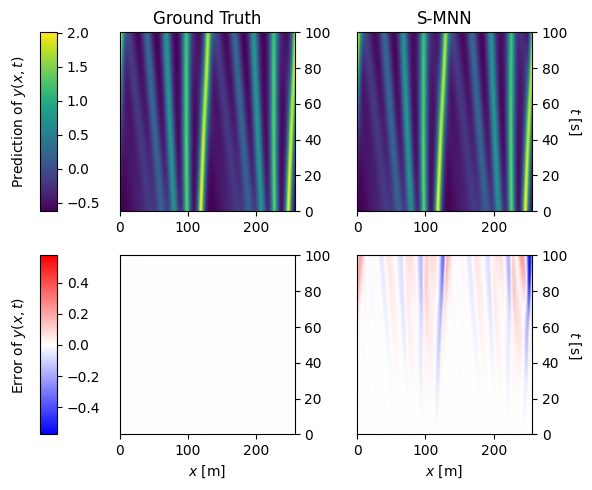

In [10]:
length = 100

kdv_gt = true_trajectory[:, datamodule.steps_per_example: datamodule.steps_per_example + length].cpu()
kdv_smnn = trajectories[:, datamodule.steps_per_example: datamodule.steps_per_example + length].cpu()

error_smnn = kdv_smnn - kdv_gt

sample_id = 10

# Determine the color range based on kdv_gt
vmin = kdv_gt[sample_id].min()
vmax = kdv_gt[sample_id].max()

evmax = error_smnn[sample_id].abs().max()

# Create a 1x3 subplot
fig, axs = plt.subplots(2, 2 + 1, figsize=(6., 5.), gridspec_kw={'width_ratios': [.1, 1., 1.]})

# Plot for KdV gt
im1 = axs[0, 1].imshow(kdv_gt[sample_id], extent=(0, 256, 0, length), cmap='viridis', origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
im1e = axs[1, 1].imshow(torch.zeros_like(kdv_gt[sample_id]), extent=(0, 256, 0, length), cmap='bwr', origin='lower', aspect='auto', vmin=-evmax, vmax=evmax)
axs[0, 1].set_title('Ground Truth')
axs[1, 1].set_xlabel('$x$ [m]')
axs[0, 1].yaxis.set_ticks_position('right')
axs[0, 1].yaxis.set_label_position('right')
axs[1, 1].yaxis.set_ticks_position('right')
axs[1, 1].yaxis.set_label_position('right')

# Plot for KdV smnn
im2 = axs[0, 2].imshow(kdv_smnn[sample_id], extent=(0, 256, 0, length), cmap='viridis', origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
im2e = axs[1, 2].imshow(error_smnn[sample_id], extent=(0, 256, 0, length), cmap='bwr', origin='lower', aspect='auto', vmin=-evmax, vmax=evmax)
axs[0, 2].set_title('S-MNN')
axs[1, 2].set_xlabel('$x$ [m]')
axs[0, 2].yaxis.set_ticks_position('right')
axs[0, 2].yaxis.set_label_position('right')
axs[1, 2].yaxis.set_ticks_position('right')
axs[1, 2].yaxis.set_label_position('right')
axs[0, 2].set_ylabel('$t$ [s]', rotation=270, labelpad=10, loc='center')
axs[1, 2].set_ylabel('$t$ [s]', rotation=270, labelpad=10, loc='center')

# Add a color bar to the right of the plots
cbar = fig.colorbar(im1, cax=axs[0, 0], orientation='vertical')
cbar.set_label('Prediction of $y(x, t)$', labelpad=-65, loc='center')

cbar = fig.colorbar(im2e, cax=axs[1, 0], orientation='vertical')
cbar.set_label('Error of $y(x, t)$', labelpad=-65, loc='center')

plt.gcf().set_facecolor((1., 1., 1., 0.))
plt.tight_layout()
plt.show()

Compute loss.

In [11]:
length = 40

true_x = true_trajectory[:, datamodule.steps_per_example: datamodule.steps_per_example + length]
prediction = trajectories[:, datamodule.steps_per_example: datamodule.steps_per_example + length]

loss = (prediction - true_x).pow(2).sum(dim=-1) / prediction.pow(2).sum(dim=-1)
loss = loss.mean().item()

print(loss)

0.0011383326491340995
